# 기계학습 - 2022년 2학기
### 과제2. 다중계층 신경망을 이용한 얼굴 표정 분류기 작성

과제 문의: 전북대학교 컴퓨터공학부 시각 및 학습 연구실 (공과대학 7호관 7619)

이번 과제에서는 사람 얼굴의 표정 데이터셋(Toronto Faces Dataset, [TFD](http://aclab.ca/users/josh/TFD.html))을 분류하는 다중계층 신경망(Multi-Layer Neural Net)을 구현하고 테스트 합니다.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import imp
try:
    imp.find_module('jupyterplot')
except ImportError:
    %pip install jupyterplot
    pass

from jupyterplot import ProgressPlot

C:\Users\YJK\AppData\Local\Temp\ipykernel_2380\1595613371.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
#### Please DO NOT DELETE this cell. ###

def LoadData(fname):
    """Loads data from an NPZ file.

    Args:
        fname: NPZ filename.

    Returns:
        data: Tuple {inputs, target}_{train, valid, test}.
              Row-major, outer axis to be the number of observations.
    """
    npzfile = np.load(fname)

    inputs_train = npzfile['inputs_train'].T / 255.0
    inputs_valid = npzfile['inputs_valid'].T / 255.0
    inputs_test = npzfile['inputs_test'].T / 255.0
    target_train = npzfile['target_train'].tolist()
    target_valid = npzfile['target_valid'].tolist()
    target_test = npzfile['target_test'].tolist()

    num_class = max(target_train + target_valid + target_test) + 1
    target_train_1hot = np.zeros([num_class, len(target_train)])
    target_valid_1hot = np.zeros([num_class, len(target_valid)])
    target_test_1hot = np.zeros([num_class, len(target_test)])

    for ii, xx in enumerate(target_train):
        target_train_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_valid):
        target_valid_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(target_test):
        target_test_1hot[xx, ii] = 1.0

    inputs_train = inputs_train.T
    inputs_valid = inputs_valid.T
    inputs_test = inputs_test.T
    target_train_1hot = target_train_1hot.T
    target_valid_1hot = target_valid_1hot.T
    target_test_1hot = target_test_1hot.T
    return inputs_train, inputs_valid, inputs_test, target_train_1hot, target_valid_1hot, target_test_1hot


training dataset
inputs: (3374, 2304) targets: (3374, 7)
validation dataset
inputs: (419, 2304) targets: (419, 7)
test dataset
inputs: (385, 2304) targets: (385, 7)


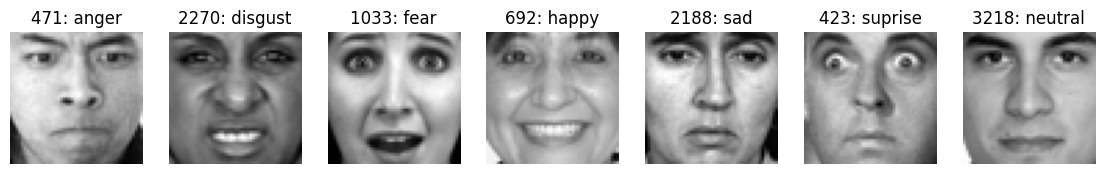

In [3]:
data = LoadData('./toronto_face.npz')
inputs = data[:3]
targets = data[3:]
inputs = {k:v for k, v in zip(['train', 'valid', 'test'], inputs)}
targets = {k:v for k, v in zip(['train', 'valid', 'test'], targets)}

print('training dataset')
print('inputs:', inputs['train'].shape, 'targets:', targets['train'].shape)
print('validation dataset')
print('inputs:', inputs['valid'].shape, 'targets:', targets['valid'].shape)
print('test dataset')
print('inputs:', inputs['test'].shape, 'targets:', targets['test'].shape)

classes = ['anger', 'disgust', 'fear', 'happy', 'sad', 'suprise', 'neutral']
_, labels = np.nonzero(targets['train'])

figs, axes = plt.subplots(nrows=1, ncols=7, figsize=(14,7))
for idx in range(7):
    axis = axes[idx]
    rnd_idx = np.random.choice(np.nonzero(labels == idx)[0])
    axis.axis('off')
    axis.imshow(inputs['train'][rnd_idx].reshape(48, 48), cmap='gray')
    axis.set_title('{}: {}'.format(rnd_idx, classes[idx]))
plt.show()

### Training Multi-layer Neural Networks


1. 기본적인 일반화 (basic generalization): 코드에 주어진 hyperparameter 들을 이용하여 신경망을 학습시킨다. 학습 오차(training error)와 일반화를 위한 검증 오차(validation error) 결과가 어떻게 다른지 설명한다. 두 가지 경우(학습과 일반화 검증)에 대해 오차 커브(error curve)를 그래프로 제시하시오.

2. 최적화 (optimization):  Learning rate, momentum, mini-batch size 세 가지 종류의 parameter 들을 아래와 같이 변화시키면서 다양한 조합들에 대해 신경망이 cross-entropy 관점에서 어떻게 수렴하는지 살펴본다. 가장 우수한 성능을 나타내는 hyperparameter 들의 조합이 어떤 것인지 제시하시오. (모든 경우의 수를 다 따지면 75 가지 신경망 모델을 테스트해야 하나 시간이 너무 많이 결릴 수 있으므로 이 중에서 일부분의 경우들만 테스트해도 된다. 그러나 어떤 근거로 해당 조합들만 테스트했는지 적당한 설명이 있어야 함.)
    - Learning rate ( $\epsilon$ ): 0.001 에서 1.0 사이의 5 가지 경우
    - Momentum: 0.0 에서 0.9 사이의 3 가지 경우
    - Mini-batch size: 1 에서 1000 까지의 5 가지 경우

3. 신경망 모델 구조 변경: Momentum 을 0.9로 고정시킨 상태에서 신경망의 hidden unit 들의 갯수를 2 에서 100 사이의 3 가지 다른 경우에 대해 성능을 비교한다. 필요한 경우 learning rate 와 학습 기간(epochs)은 신경망 구조에 따라 적당하게 변경할 수 있다. Hidden unit 의 갯수들이 학습에서의 수렴과 신경망의 일반화 성는에 미치는 영향에 대한 데이터(표나 그래프)를 제시하고 경향을 분석하시오.

In [4]:
def Save(fname, data):
    print('Writing to ' + fname)
    np.savez_compressed(fname, **data)


def Load(fname):
    print('Loading from ' + fname)
    return dict(np.load(fname))

In [5]:
def Affine(x, w, b):
    y = x.dot(w) + b
    return y

def ReLU(x):
    return np.maximum(x, 0.0)

def Softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)

def InitNN(num_inputs, num_hiddens, num_outputs):
    W1 = 0.1 * np.random.randn(num_inputs, num_hiddens[0])
    W2 = 0.1 * np.random.randn(num_hiddens[0], num_hiddens[1])
    W3 = 0.01 * np.random.randn(num_hiddens[1], num_outputs)
    b1 = np.zeros((num_hiddens[0]))
    b2 = np.zeros((num_hiddens[1]))
    b3 = np.zeros((num_outputs))
    model = {
        'W1': W1,
        'W2': W2,
        'W3': W3,
        'b1': b1,
        'b2': b2,
        'b3': b3
    }
    return model

def NNForward(model, x):
    h1 = Affine(x, model['W1'], model['b1'])
    h1r = ReLU(h1)
    h2 = Affine(h1r, model['W2'], model['b2'])
    h2r = ReLU(h2)
    y = Affine(h2r, model['W3'], model['b3'])
    var = {
        'x': x,
        'h1': h1,
        'h1r': h1r,
        'h2': h2,
        'h2r': h2r,
        'y': y
    }
    return var

In [6]:
def AffineBackward(grad_y, x, w):
    grad_x = grad_y.dot(w.T)
    grad_w = x.T.dot(grad_y)
    grad_b = np.sum(grad_y, axis=0)
    return grad_x, grad_w, grad_b
    raise Exception('Not implemented')

In [7]:
def ReLUBackward(grad_y, x, y):
    grad_x = grad_y * (x > 0)
    return grad_x
    raise Exception('Not implemented')

In [8]:
def NNBackward(model, err, var):
    dE_dh2r, dE_dW3, dE_db3 = AffineBackward(err, var['h2r'], model['W3'])
    dE_dh2 = ReLUBackward(dE_dh2r, var['h2'], var['h2r'])
    dE_dh1r, dE_dW2, dE_db2 = AffineBackward(dE_dh2, var['h1r'], model['W2'])
    dE_dh1 = ReLUBackward(dE_dh1r, var['h1'], var['h1r'])
    _, dE_dW1, dE_db1 = AffineBackward(dE_dh1, var['x'], model['W1'])
    model['dE_dW1'] = dE_dW1
    model['dE_dW2'] = dE_dW2
    model['dE_dW3'] = dE_dW3
    model['dE_db1'] = dE_db1
    model['dE_db2'] = dE_db2
    model['dE_db3'] = dE_db3
    pass

In [9]:
def NNUpdate(model, eps, momentum):
    model['W1'] -= eps * model['dE_dW1'] + momentum * model.get('V_dE_dW1', 0)
    model['W2'] -= eps * model['dE_dW2'] + momentum * model.get('V_dE_dW2', 0)
    model['W3'] -= eps * model['dE_dW3'] + momentum * model.get('V_dE_dW3', 0)
    model['b1'] -= eps * model['dE_db1'] + momentum * model.get('V_dE_db1', 0)
    model['b2'] -= eps * model['dE_db2'] + momentum * model.get('V_dE_db2', 0)
    model['b3'] -= eps * model['dE_db3'] + momentum * model.get('V_dE_db3', 0)


### 훈련

In [10]:
def Train(model, forward, backward, update, eps, momentum, num_epochs,
          batch_size):
    inputs_train, inputs_valid, inputs_test, target_train, target_valid, \
        target_test = LoadData('./toronto_face.npz')
    rnd_idx = np.arange(inputs_train.shape[0])
    train_ce_list = []
    valid_ce_list = []
    train_acc_list = []
    valid_acc_list = []
    
    num_train_cases = inputs_train.shape[0]
    if batch_size == -1:
        batch_size = num_train_cases
    num_steps = int(np.ceil(num_train_cases / batch_size))

    pp = ProgressPlot(
        plot_names=['Cross entropy', 'Accuracy'],
        line_names=['Train', 'Validation'],
        x_label='Iteration',
        x_lim=[0, num_epochs*num_steps]
    )

    valid_ce = 0
    valid_acc = 0
    for epoch in range(num_epochs):
        np.random.shuffle(rnd_idx)
        inputs_train = inputs_train[rnd_idx]
        target_train = target_train[rnd_idx]
        for step in range(num_steps):
            # Forward prop.
            start = step * batch_size
            end = min(num_train_cases, (step + 1) * batch_size)
            x = inputs_train[start: end]
            t = target_train[start: end]

            var = forward(model, x)
            prediction = Softmax(var['y'])

            train_ce = -np.sum(t * np.log(prediction)) / x.shape[0]
            train_acc = (np.argmax(prediction, axis=1) ==
                         np.argmax(t, axis=1)).astype('float').mean()
            pp.update([[train_ce, valid_ce], [train_acc, valid_acc]])

            # Compute error.
            error = (prediction - t) / x.shape[0]

            # Backward prop.
            backward(model, error, var)

            # Update weights.
            update(model, eps, momentum)

        valid_ce, valid_acc = Evaluate(
            inputs_valid, target_valid, model, forward, batch_size=batch_size)
        
        pp.update([[train_ce, valid_ce], [train_acc, valid_acc]])
        train_ce_list.append((epoch, train_ce))
        train_acc_list.append((epoch, train_acc))
        valid_ce_list.append((epoch, valid_ce))
        valid_acc_list.append((epoch, valid_acc))

    # print()
    train_ce, train_acc = Evaluate(
        inputs_train, target_train, model, forward, batch_size=batch_size)
    valid_ce, valid_acc = Evaluate(
        inputs_valid, target_valid, model, forward, batch_size=batch_size)
    test_ce, test_acc = Evaluate(
        inputs_test, target_test, model, forward, batch_size=batch_size)
    print('CE: Train %.5f Validation %.5f Test %.5f' %
          (train_ce, valid_ce, test_ce))
    print('Acc: Train {:.5f} Validation {:.5f} Test {:.5f}'.format(
        train_acc, valid_acc, test_acc))
    pp.finalize()
    stats = {
        'train_ce': train_ce_list,
        'valid_ce': valid_ce_list,
        'train_acc': train_acc_list,
        'valid_acc': valid_acc_list
    }

    return model, stats

def Evaluate(inputs, target, model, forward, batch_size=-1):
    num_cases = inputs.shape[0]
    if batch_size == -1:
        batch_size = num_cases
    num_steps = int(np.ceil(num_cases / batch_size))
    ce = 0.0
    acc = 0.0
    for step in range(num_steps):
        start = step * batch_size
        end = min(num_cases, (step + 1) * batch_size)
        x = inputs[start: end]
        t = target[start: end]
        prediction = Softmax(forward(model, x)['y'])
        ce += -np.sum(t * np.log(prediction))
        acc += (np.argmax(prediction, axis=1) == np.argmax(
            t, axis=1)).astype('float').sum()
    ce /= num_cases
    acc /= num_cases
    return ce, acc

In [11]:
def CheckGrad(model, forward, backward, name, x):
    np.random.seed(0)
    var = forward(model, x)
    loss = lambda y: 0.5 * (y ** 2).sum()
    grad_y = var['y']
    backward(model, grad_y, var)
    grad_w = model['dE_d' + name].ravel()
    w_ = model[name].ravel()
    eps = 1e-7
    grad_w_2 = np.zeros(w_.shape)
    check_elem = np.arange(w_.size)
    np.random.shuffle(check_elem)
    # Randomly check 20 elements.
    check_elem = check_elem[:20]
    for ii in check_elem:
        w_[ii] += eps
        err_plus = loss(forward(model, x)['y'])
        w_[ii] -= 2 * eps
        err_minus = loss(forward(model, x)['y'])
        w_[ii] += eps
        grad_w_2[ii] = (err_plus - err_minus) / 2 / eps
    np.testing.assert_almost_equal(grad_w[check_elem], grad_w_2[check_elem],
                                   decimal=3)


def main():
    """Trains a NN."""
    model_fname = 'nn_model.npz'
    stats_fname = 'nn_stats.npz'

    # Hyper-parameters. Modify them if needed.
    num_hiddens = [8, 16]
    eps = 0.01
    momentum = 0.9
    num_epochs = 1000
    batch_size = 64

    # Input-output dimensions.
    num_inputs = 2304
    num_outputs = 7

    # Initialize model.
    model = InitNN(num_inputs, num_hiddens, num_outputs)

    # Uncomment to reload trained model here.
    # model = Load(model_fname)

    # Check gradient implementation.
    print('Checking gradients...')
    x = np.random.rand(10, 48 * 48) * 0.1
    CheckGrad(model, NNForward, NNBackward, 'W3', x)
    CheckGrad(model, NNForward, NNBackward, 'b3', x)
    CheckGrad(model, NNForward, NNBackward, 'W2', x)
    CheckGrad(model, NNForward, NNBackward, 'b2', x)
    CheckGrad(model, NNForward, NNBackward, 'W1', x)
    CheckGrad(model, NNForward, NNBackward, 'b1', x)

    # Train model.
    trained_model, stats = Train(model, NNForward, NNBackward, NNUpdate, eps,
                  momentum, num_epochs, batch_size)

    plt.figure(0)
    plt.plot(np.array(stats['train_ce'])[:, 0], np.array(stats['train_ce'])[:, 1], 'b', label='Train')
    plt.plot(np.array(stats['valid_ce'])[:, 0], np.array(stats['valid_ce'])[:, 1], 'orange', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.legend()

    plt.figure(1)
    plt.plot(np.array(stats['train_acc'])[:, 0], np.array(stats['train_acc'])[:, 1], 'b', label='Train')
    plt.plot(np.array(stats['valid_acc'])[:, 0], np.array(stats['valid_acc'])[:, 1], 'orange', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Uncomment if you wish to save the model.
    # Save(model_fname, model)

    # Uncomment if you wish to save the training statistics.
    # Save(stats_fname, stats)

In [ ]:
main()

<a id='Training Multi-Layer Neaural Networks'></a>
#### 1. 기본적인 일반화 ####

![plot sample](./image01.png)

- 학습을 진행할수록 모델이 train 데이터에 의존하는 경향이 커짐으로써 train data의 loss는 줄어들지만 validation 데이터의 loss 는 늘어난다. </br>
반대로 정확도는 train 은 커지고 validation 은 줄어들어 학습이 진행될수록 과적합(overfitting)이 되고 있다는 것을 알 수가 있다.

#### 2. 최적의 하이퍼 파라미터 찾기 ####

- 먼저 local minimum (지역 최솟값)을 벗어나기 위한 연산 momentum 은 보통 0.9에 사용한다 하여 momentum = 0.9로 테스트를 해보았다. </br>
- 최적의 learningrate(eps)를 찾기 위하여 minibatch_size(=64)는 고정해두었다.

learning late 가 1인 경우</br>

![plot sample](./image02.png)

eps = 0.01

![plot sample](./image03.png)

eps = 0.001

![plot sample](./image04.png)

- learning rate가 클경우(0.1) 모델이 수렴하지 않고 파라미터 값이 크게 튀는 현상을 보이고 있다. </br>
이로 인해 수렴이 불안정하면 loss 값이 크게 나와 모델이 불안해진다.
- learning rate가 작을 경우(0.001) 지역 최솟값(local minimum)에 갇히게 되어 최적의 모델 파라미터를 찾지 못한다. </br>
또한 가중치와 편향이 더 이상 업데이트가 되지 않아 모델이 더이상 발전하지 못하고 성틍 향상이 멈추게 되는 현상을 보인다.
- 이를 통하여 learning rate 는 0.01이 최적화 된 값임을 도출하게 되었다.

- minibatchsize 같은 경우 2의 제곱수일때 데이터 송수신 및 연산에 효율적이라 일반적으로 32, 64, 128, 256 수치를 사용한다. </br>


- batch_size = 128 인 경우</br>
![plot sample](./image05.png)

- batch_size = 64 인 경우</br>
![plot sample](./image06.png)

- 32 인 경우 연산 속도가 느려져 64개와 128개 중 고려하였다. </br>
size 가 클수록 학습이 빠르지만 한번에 처리하는 양이 많아져 학습이 불안정하는 모습을 보여  batch_szie= 64로 지정하였다.

- momentum = 0.8 </br>

![plot sample](./image07.png)

- momentum = 0.5 </br>

![plot sample](./image08.png)

- momentum = 0.4 </br>

![plot sample](./image09.png)

- 모멘텀 같은 경우 보통 0.9를 사용하지만 0.9에서 값을 내린경우 loss값이 내려가고 정확도가 올라가는 모습을 보이고 있다. </br>
모멘텀이 큰 경우 그래디언트에 민감해지기 때문에 모델에 노이즈가 있을 경우 올바른 방향으로 모델이 수렴하지 못하는 현상을 보인다. </br>
학습 초기에는 이전의 그래디언트 업데이트가 큰 영향을 주기 때문에 학습 초기에 모델이 발산할 가능성이 크기 때문에 모멘텀을 줄였더니 성능이 잘 나오는 효과를 보이게 되었다. </br>
반대로 값이 작은경우 모델이 느리게 수렴하고 그래디언트의 변화가 클 경우 모델이 발산하는 현상을 보이고 있다.

- 이를 통하여 최적의 파라미터는 </br>
eps = 0.01
momentum = 0.5
batch_size = 64

#### 3.Hidden unit 의 개수들이 학습에서의 수렴과 신경망의 일반화 성능에 미치는 영향 ####

- eps = 0.01, momentum - 0.9, batch_size = 64, epoch = 500 고정 </br>

- num_hiddens = [8, 16] (24개) </br>

![plot sample](./image10.png)

- num_hiddens = [16, 32] (48개) </br>

![plot sample](./image11.png)

- num_hiddens = [32, 64] (96개) </br>

![plot sample](./image12.png)


- 위 그래프를 통하여  hidden units의 개수가 많아질수록 복잡한 함수를 학습할 수 있다. </br>
 hidden units의 개수가 많아질수록 train 데이터 accuracy가 늘어나는 모습을 보이고 있다. </br>
 이는 과적합  (overfitting)을 보이고 있다.</br>
 epoch을 전 단계보단 반으로 줄였기 때문에 다시 1000회를 시도해 보았다.</br>
 
 ![plot sample](./image12.png)
    </br>num_hiddens = [32, 64] </br>
    eps = 0.01 </br>
    momentum = 0.9 </br>
    num_epochs = 1000 </br>
    batch_size = 64 </br>

학습 횟수가 늘다보니 모델이 더 복잡해져 모델이 수렴하지 못하고 발산하게 된다. </br>